In [3]:
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt



In [4]:
from typing import Tuple


@dataclass
class Point2D:
    x: float
    y: float

    def as_tuple(self) -> Tuple[float, float]:
        return (self.x, self.y)


@dataclass
class Line2D:
    slope: float
    intercept: float

    def __call__(self, data: np.ndarray):
        return self.intercept + self.slope * data

    def coeffs(self) -> np.ndarray:
        # Equation is y = slope * x + intercept
        # Rearranging, -slope * x + y = intercept
        return np.array([-self.slope, 1.0])

    def intersect(self, other: "Line2D") -> Point2D:
        # Solve Ax = b
        A = np.array([self.coeffs(), other.coeffs()])
        b = np.array([self.intercept, other.intercept])
        result = np.linalg.solve(A, b)
        return Point2D(result[0], result[1])



In [5]:
line1 = Line2D(1.0, -5.0)
line2 = Line2D(-2.0, 24.4)

In [6]:
def plot_intersection(line1: Line2D, line2: Line2D):
    x = np.linspace(-50, 50)
    y1 = line1(x)
    y2 = line2(x)

    plt.plot(x, y1)
    plt.plot(x, y2)

    try:
        intersection = line1.intersect(line2)

        plt.annotate(intersection, intersection.as_tuple(), (intersection.x, intersection.y + 100), 
                    arrowprops={"arrowstyle": "->"})
    except np.linalg.LinAlgError:
        print("No solution")    



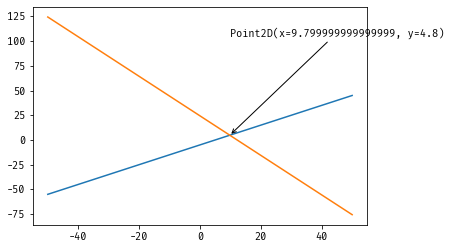

In [7]:
plot_intersection(line1, line2)

No solution


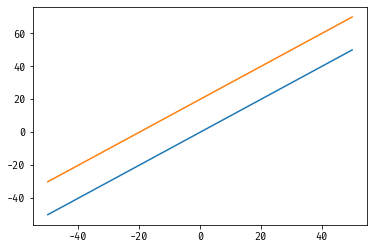

In [8]:
plot_intersection(Line2D(1, 0), Line2D(1, 20))

In [233]:
@dataclass
class LineSegment2D:
    start: Point2D
    end: Point2D
        
    def points(self) -> np.ndarray:
        return np.array([self.start.as_tuple(), self.end.as_tuple()])

    def line(self) -> Line2D:
        dx = self.end.x - self.start.x
        dy = self.end.y - self.start.y
        slope = dy/dx
        intercept = self.start.y - self.start.x * slope
        return Line2D(slope, intercept)
    
    def intersect(self, other: "LineSegment2D") -> Point2D:
        # First check if the lines intersect
        line_intersection = self.line().intersect(other.line())
        # If it does then the intersection point must lie within both segments
        x_coord = line_intersection.x
        if x_coord < self.start.x or x_coord < other.start.x or x_coord > self.end.x or x_coord > other.end.x:
            raise ValueError("No intersection")            
        else:
            return line_intersection
        



In [234]:
def plot_intersection_segments(line_segment1: LineSegment2D, line_segment2: LineSegment2D):
        plt.plot(*line_segment1.points().transpose())
        plt.plot(*line_segment2.points().transpose())
        
        try:
            intersection = line_segment1.intersect(line_segment2)

            plt.annotate(intersection, intersection.as_tuple(), (-100, -100), textcoords="offset points", 
                        arrowprops={"arrowstyle": "->"})
        except Exception as e:
            plt.title(e)

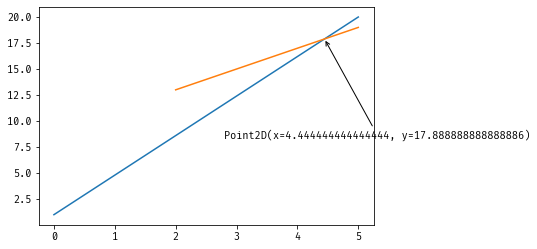

In [235]:
ls1 = LineSegment2D(start=Point2D(0, 1), end=Point2D(5, 20))
ls2 = LineSegment2D(start=Point2D(2, 13), end=Point2D(5, 19))

plot_intersection_segments(ls1, ls2)

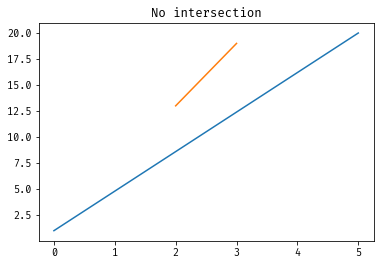

In [236]:
ls1 = LineSegment2D(start=Point2D(0, 1), end=Point2D(5, 20))
ls2 = LineSegment2D(start=Point2D(2, 13), end=Point2D(3, 19))

plot_intersection_segments(ls1, ls2)

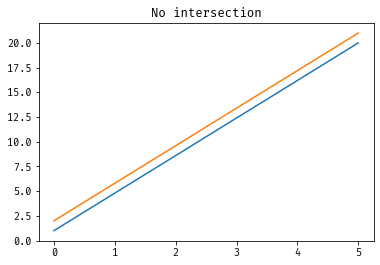

In [237]:
ls1 = LineSegment2D(start=Point2D(0, 1), end=Point2D(5, 20))
ls2 = LineSegment2D(start=Point2D(0, 2), end=Point2D(5, 21))

plot_intersection_segments(ls1, ls2)

# 3D intersections

If two lines intersect in three dimensions, then they must lie on a common 2D plane, and within that the methods used above to solve for 2D lines are sufficient.

Determine if two 3D lines share a plane by constructing two triangles using two points from one line to one point from the other line (but using at least one distinct point so we are not comparing the same triangle). If the triangles share a plane, the lines share a plane.

In [238]:
from scipy.spatial.transform import Rotation

class Mixin3D:
    def as_array(self) -> np.ndarray:
        return np.array([self.x, self.y, self.z])
    
    def __eq__(self, other: 'Vector3D') -> bool:
        # Test approximate equality
        return np.all(np.abs(self.as_array() - other.as_array()) < 1e-8)        

    def __add__(self, other: 'Vector3D') -> 'Vector3D':
        return self.__class__(*(self.as_array() + other.as_array()))

    def __sub__(self, other: 'Vector3D') -> 'Vector3D':
        return Vector3D(*(self.as_array() - other.as_array()))
    
    def is_zero(self) -> bool:
        return np.linalg.norm(self.as_array()) == 0.0

@dataclass
class Vector3D(Mixin3D):
    x: float
    y: float
    z: float
        
    def cross(self, other: "Vector3D") -> "Vector3D":
        result = np.cross(self.as_array(), other.as_array())
        return Vector3D(*result)
    
    def normalised(self) -> "Vector3D":
        return Vector3D(*(self.as_array() / np.linalg.norm(self.as_array())))
    
    def is_parallel(self, other: "Vector3D") -> bool:
        return np.abs(np.dot(self.as_array(), other.as_array())) > 1 - 1e-10
    
    def rotation_to(self, other: "Vector3D") -> Rotation:
        cp = np.cross(self.normalised().as_array(), other.normalised().as_array())
        norm = np.linalg.norm(cp)
        angle = np.arcsin(norm)
        return Rotation.from_rotvec((cp / norm) * angle)
    
@dataclass
class Point3D(Mixin3D):
    x: float
    y: float
    z: float
        
@dataclass
class Triangle3D:
    a: Point3D
    b: Point3D
    c: Point3D
        
    def normal_vec(self) -> Vector3D:
        v1 = self.b - self.a
        v2 = self.c - self.b
        normal = v1.cross(v2)
        return normal.normalised()
    


In [239]:
# Sanity check triangle plane calculation
a = Point3D(0, 0, 0)
b = Point3D(0, 20, 0)
c = Point3D(1, 0, 0)
Triangle3D(a, b, c).normal_vec()

Vector3D(x=0.0, y=0.0, z=-1.0)

In [240]:
@dataclass
class Line3D:
    # Some point anywhere along the line
    point: Point3D
    # Vector giving the direction of the line.
    # All points on the line are thus self.point + scalar * self.direction
    # Naturally this vector must be non-zero. In __post_init__ we will normalise
    # it to a unit vector
    direction: Vector3D
        
    def __post_init__(self):
        if self.direction.is_zero():
            raise ValueError("Direction vector must not be zero")
        self.direction = self.direction.normalised()
        
    def offset(self, scalar: float) -> Point3D:
        return Point3D(*(self.point.as_array() + scalar * self.direction.as_array()))
        
    def shared_plane(self, other: "Line3D") -> Vector3D:
        """Calculate the shared plane, if it exists, and return a normal vector"""
        if self.direction.is_parallel(other.direction):
            # Directions are identical
            points_diff = (other.point - self.point)
            
            if points_diff.is_zero() or points_diff.normalised().is_parallel(self.direction):
                # Lines are literally the same, so the problem is underconstrained
                # Just pick any plane parallel to the direction
                if self.direction == Vector3D(1, 0, 0):
                    # Direction is X axis, return Y axis as normal
                    return Vector3D(0, 1, 0)
                else:
                    # Direction is not X axis, return X axis cross direction
                    # as that will be normal to both
                    return Vector3D(1, 0, 0).cross(self.direction)
                
        points_diff = (other.point - self.point)
        
        if points_diff.is_zero() or points_diff.normalised().is_parallel(self.direction):
            # Directions are not the same, but the point used for the other line is somewhere
            # on the current line which is going to lead to a degenerate triangle. 
            # Move the other point along its direction (which we've established isn't parallel,
            # so it will give a triangle)
            extra_offset = 0.4
        else:
            extra_offset = 0.0
            
        triangle1 = Triangle3D(self.offset(0.0), self.offset(1.0), other.offset(extra_offset))
        triangle2 = Triangle3D(self.offset(5.0), self.offset(25.0), other.offset(5.0 + extra_offset))

        normal1 = triangle1.normal_vec()
        normal2 = triangle2.normal_vec()
        
        if normal1.is_parallel(normal2):
            return normal1
        else:
            raise ValueError("Not a shared plane")
        
    def intersect(self, other: "Line3D") -> Point3D:
        """Find the point where this line intersects another, if they do."""
        plane = self.shared_plane(other)
        
        # Rotate the plane so that the lines are in X-Y coordinates and we can
        # use the Line2D classes
        rot = plane.rotation_to(Vector3D(0, 0, 1))
        
        self_a = self.point.as_array()
        self_b = (self.point + self.direction).as_array()
        other_a = other.point.as_array()
        other_b = (other.point + other.direction).as_array()
        rotated = rot.apply([self_a, self_b, other_a, other_b])
        
        self_2d = LineSegment2D(Point2D(*rotated[0,:2]), Point2D(*rotated[1,:2])).line()
        other_2d = LineSegment2D(Point2D(*rotated[2,:2]), Point2D(*rotated[3,:2])).line()
        
        intersect_2d = self_2d.intersect(other_2d)
        intersect_3d = rot.inv().apply([intersect_2d.x, intersect_2d.y, rotated[0,2]])
        return Point3D(*intersect_3d)

In [241]:
# Sanity checks - first some lines in the x-y plane, first sharing an origin and second not
origin = Point3D(0, 0, 0)
dir1 = Vector3D(1, 0, 0)
dir2 = Vector3D(1, 1, 0)

plane1 = Line3D(origin, dir1).shared_plane(Line3D(origin, dir2))
plane2 = Line3D(origin, dir1).shared_plane(Line3D(Point3D(-2, 0, 0), dir2))

assert plane1.is_parallel(Vector3D(0, 0, 1))
assert plane2.is_parallel(Vector3D(0, 0, 1))

In [242]:
# Sanity checks - line directions are in the x-y plane, by the lines are offset in the z direciton
# therefore they do not actually share a plane

try:
    Line3D(origin, dir1).shared_plane(Line3D(Point3D(-2, 0, 1), dir2))
    assert false
except ValueError as e:
    assert str(e) == "Not a shared plane"

In [243]:
origin = Point3D(0.5, 0.5, 0.8)
dir1 = Vector3D(1, 0, 0.5)
dir2 = Vector3D(-1, 1.4, 0.1)
line1 = Line3D(origin, dir1)
line2 = Line3D(origin, dir2)
line1.intersect(line2)

Point3D(x=0.5, y=0.4999999999999999, z=0.8)